This section of the notebook focuses on preparing the modules and the dataset for work 

In [3]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("../data/master_f1_dataset_2025.csv")
df

Driver  fp2_avg_lap  fp2_best_lap  fp2_total_laps  FastestQualiLap  \
0      ALB    92.966765        77.302              17           75.737   
1      ALO    91.150048        77.330              21           76.288   
2      ANT    85.246222        77.634              18           76.525   
3      BOR    86.275188        77.847              16           76.516   
4      DOO    91.787609        77.394              23           76.315   
..     ...          ...           ...             ...              ...   
249    RUS   110.381929       102.598              14          101.254   
250    SAI   110.604667       103.217               6          101.691   
251    STR   116.369857       103.112               7          102.502   
252    TSU   109.272818       104.492              11          101.245   
253    VER   106.553200       102.426              10          100.903   

     QualiPosition  RacePosition    DNF grand_prix  
0                6             5  False  Australia  
1               12            21   True  Australia  
2               16             4  False  Australia  
3               15            21   True  Australia  
4               13            21   True  Australia  
..             ...           ...    ...        ...  
249              7             5  False    Belgium  
250             15            18  False    Belgium  
251             20            14  False    Belgium  
252              6            13   True    Belgium  
253              4             4  False    Belgium  

[254 rows x 9 columns]

In [6]:
df["is_podium_finish"] = df["RacePosition"] <= 3
print(df["is_podium_finish"].value_counts())

is_podium_finish
False    215
True      39
Name: count, dtype: int64


Here we identify the features we want to use and divide the data into a train and test splits

In [7]:
X = df.drop(columns=["RacePosition", "DNF", "grand_prix", "is_podium_finish", "Driver"])
y = df["is_podium_finish"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22, stratify=y)

print(X.columns)
print(X.dtypes)

Index(['fp2_avg_lap', 'fp2_best_lap', 'fp2_total_laps', 'FastestQualiLap',
       'QualiPosition'],
      dtype='object')
fp2_avg_lap        float64
fp2_best_lap       float64
fp2_total_laps       int64
FastestQualiLap    float64
QualiPosition        int64
dtype: object


The next four cells focus on trying different types of models to see which one gives the best results for our prediction model. I tried Random Forest Classifier, Gradient Boosting Classifier, Logistic Regression With Quali Position, and Logistic Regression Without Quali Position.

RandomForestClassifier:
              precision    recall  f1-score   support

       False       0.91      1.00      0.95        40
        True       1.00      0.43      0.60         7

    accuracy                           0.91        47
   macro avg       0.95      0.71      0.78        47
weighted avg       0.92      0.91      0.90        47



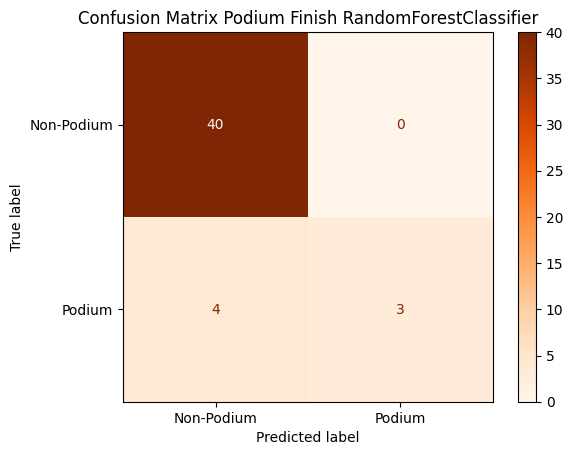

In [144]:
RFC_model = RandomForestClassifier(class_weight='balanced', random_state=22)
RFC_model.fit(X_train,y_train)
y_pred_rfc = RFC_model.predict(X_test)

print("RandomForestClassifier:")
print(classification_report(y_test, y_pred_rfc))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rfc,
    display_labels=['Non-Podium', 'Podium'],
    cmap='Oranges',
    xticks_rotation=0
)
plt.title("Confusion Matrix Podium Finish RandomForestClassifier")
plt.grid(False)
plt.show()

Gradient Boosting:
              precision    recall  f1-score   support

       False       0.91      1.00      0.95        40
        True       1.00      0.43      0.60         7

    accuracy                           0.91        47
   macro avg       0.95      0.71      0.78        47
weighted avg       0.92      0.91      0.90        47



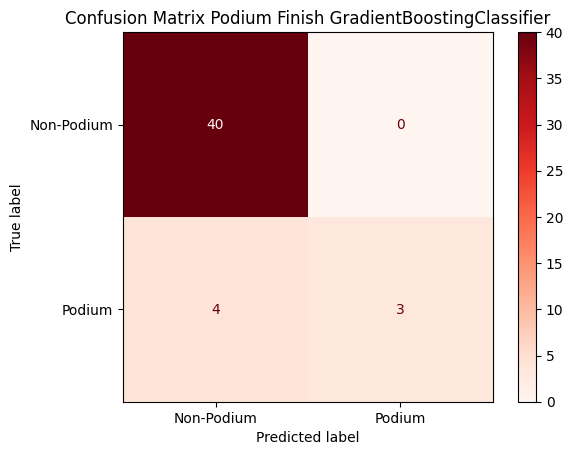

In [133]:
gb_model = GradientBoostingClassifier(random_state=22)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

print("Gradient Boosting:")
print(classification_report(y_test, y_pred_gb))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_gb,
    display_labels=['Non-Podium', 'Podium'],
    cmap='Reds',
    xticks_rotation=0
)

plt.title("Confusion Matrix Podium Finish GradientBoostingClassifier")
plt.grid(False)
plt.show()

Logistic Regression (With QualiPosition, Scaled):
              precision    recall  f1-score   support

       False       1.00      0.84      0.91        43
        True       0.53      1.00      0.70         8

    accuracy                           0.86        51
   macro avg       0.77      0.92      0.80        51
weighted avg       0.93      0.86      0.88        51



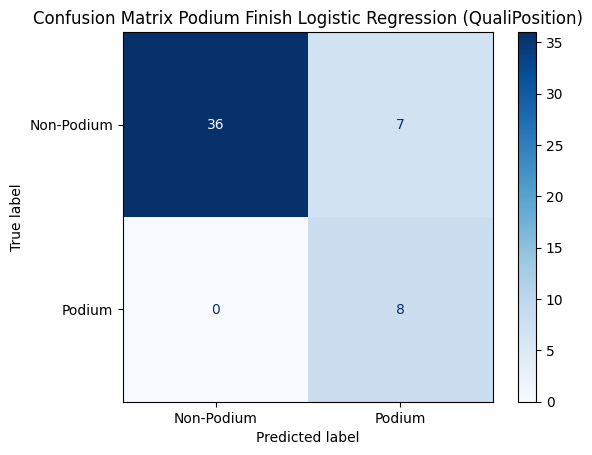

In [8]:
# scaled logistic regression
# the model that i am going to save, as it gives the best outcomes 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_model = LogisticRegression(class_weight='balanced', random_state=22)
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)

print("Logistic Regression (With QualiPosition, Scaled):")
print(classification_report(y_test, y_pred_log))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_log,
    display_labels=['Non-Podium', 'Podium'],
    cmap='Blues',
    xticks_rotation=0
)

plt.title("Confusion Matrix Podium Finish Logistic Regression (QualiPosition)")
plt.grid(False)
plt.show()

In [146]:
import pickle

# Save trained logistic regression model
with open('../models/log_model_scaled_with_quali.pkl', 'wb') as file:
    pickle.dump(log_model, file)

In [148]:
with open('../models/scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [131]:
# scaled logistic regression with no quali position data
# redefined train/test split 
X_dropped = X.drop(columns=["QualiPosition"])
X_train_dropped, X_test_dropped, y_train_dropped, y_test_dropped = train_test_split(X_dropped, y, stratify=y, random_state=22, test_size=0.2)

# rescale the data 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_dropped)
X_test_scaled = scaler.transform(X_test_dropped)

# apply logistic regression
log_model_dropped = LogisticRegression(class_weight='balanced', random_state=22)
log_model_dropped.fit(X_train_scaled, y_train_dropped)
y_pred_dropped = log_model_dropped.predict(X_test_scaled)

print("Logistic Regression (Without QualiPosition, Scaled):")
print(classification_report(y_test_dropped, y_pred_dropped))

ConfusionMatrixDisplay.from_predictions(
    y_test_dropped, y_pred_dropped,
    display_labels=['Non-Podium', 'Podium'],
    cmap='Purples',
    xticks_rotation=0
)
plt.title("Confusion Matrix Podium Finish Logistic Regression (No QualiPosition)")
plt.grid(False)
plt.show()

Logistic Regression (Without QualiPosition, Scaled):
              precision    recall  f1-score   support

       False       0.92      0.55      0.69        40
        True       0.22      0.71      0.33         7

    accuracy                           0.57        47
   macro avg       0.57      0.63      0.51        47
weighted avg       0.81      0.57      0.63        47



After comparing the models I can state that Logistic Regression With Quali Position gave the best results.

We redo the train test split to move on to the next part of the notebook.

In [ ]:
# restore the original columns from X
X = df[['fp2_avg_lap', 'fp2_best_lap', 'fp2_total_laps', 'FastestQualiLap', 'QualiPosition']]

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=22, test_size=0.2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_pred = log_model.predict(X_test_scaled)

In [52]:
# Get predicted probabilities for class 1 (podium finish)
proba_preds = log_model.predict_proba(X_test_scaled)[:, 1]

# Add predictions + metadata back to a DataFrame
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)
test_results = X_test_reset.copy()
test_results["proba_podium"] = proba_preds
test_results["Driver"] = df.loc[X_test.index, "Driver"].values
test_results["RacePosition"] = df.loc[X_test.index, "RacePosition"].values
test_results["grand_prix"] = df.loc[X_test.index, "grand_prix"].values

In [53]:
def get_top3_accuracy(df_grouped):
    correct_count = 0
    total = 0

    for race, group in df_grouped:
        # Predicted top 3 drivers by probability
        predicted_top3 = group.sort_values("proba_podium", ascending=False)["Driver"].head(3).tolist()

        # Actual top 3 drivers by RacePosition
        actual_top3 = group.sort_values("RacePosition")["Driver"].head(3).tolist()

        # Count how many predicted drivers are in the actual top 3
        correct = len(set(predicted_top3) & set(actual_top3))
        correct_count += correct
        total += 3  # Always comparing top 3

    return correct_count / total

In [54]:
grouped = test_results.groupby("grand_prix")
top3_score = get_top3_accuracy(grouped)

print(f"Top-3 Accuracy across all races: {top3_score:.2f}")

Top-3 Accuracy across all races: 0.78


In [110]:
# Can be any race from the master dataset
race_name = "Silverstone"  
race_data = df[df["grand_prix"] == race_name].copy()

In [111]:
# Select features
X_race = race_data[["fp2_avg_lap", "fp2_best_lap", "fp2_total_laps", "FastestQualiLap", "QualiPosition"]]

# Scale using previously fitted scaler 
X_race_scaled = scaler.transform(X_race)

In [112]:
race_data["proba_podium"] = log_model.predict_proba(X_race_scaled)[:, 1]

In [135]:
# As an examle we will find podium probabilities for 2025 Silverstone GP
predicted_finish = race_data.sort_values("proba_podium", ascending=False).copy()

print("Model's Top 3 Prediction for", race_name)
print(predicted_finish[["Driver", "proba_podium", "RacePosition", "QualiPosition"]])

Model's Top 3 Prediction for Silverstone
    Driver  proba_podium  RacePosition  QualiPosition
233    VER      0.856958             5              1
226    NOR      0.826489             1              3
228    PIA      0.807370             2              2
229    RUS      0.714766            10              4
222    HAM      0.666240             4              5
225    LEC      0.511439            14              6
216    ANT      0.400553            21              7
215    ALO      0.288984             9              9
217    BEA      0.229235            11              8
220    GAS      0.171044             6             10
230    SAI      0.136789            12             11
232    TSU      0.101012            21             12
221    HAD      0.079251            21             13
214    ALB      0.053818             8             14
224    LAW      0.028750            21             16
227    OCO      0.018362            13             15
223    HUL      0.016234             3   

In [117]:
# Predicted podium finishers and their actual race finish
predicted_podium = race_data.sort_values("proba_podium", ascending=False).head(3).copy()
predicted_podium["PredictedPosition"] = [1, 2, 3]  # based on model confidence
print(predicted_podium[["PredictedPosition", "Driver", "proba_podium", "RacePosition"]])

     PredictedPosition Driver  proba_podium  RacePosition
233                  1    VER      0.856958             5
226                  2    NOR      0.826489             1
228                  3    PIA      0.807370             2


We retrain the model with QualiPosition dropped in order to check how much the inclusion of QualiPosition makes the final results too predictable. 

In [98]:
# Features without QualiPosition
X_dropped = df[["fp2_avg_lap", "fp2_best_lap", "fp2_total_laps", "FastestQualiLap"]]

X_train_dropped, X_test_dropped, y_train_dropped, y_test_dropped = train_test_split(
    X_dropped, y, test_size=0.2, random_state=22, stratify=y)

scaler_dropped = StandardScaler()
X_train_dropped_scaled = scaler_dropped.fit_transform(X_train_dropped)
X_test_dropped_scaled = scaler_dropped.transform(X_test_dropped)

# Train the model
log_model_dropped = LogisticRegression()
log_model_dropped.fit(X_train_dropped_scaled, y_train_dropped)

LogisticRegression()

In [99]:
X_race_dropped = race_data[["fp2_avg_lap", "fp2_best_lap", "fp2_total_laps", "FastestQualiLap"]]
X_race_dropped_scaled = scaler_dropped.transform(X_race_dropped)

race_data["proba_podium_dropped"] = log_model_dropped.predict_proba(X_race_dropped_scaled)[:, 1]

race_name = "Silverstone"
race_data_dropped = df[df["grand_prix"] == race_name].copy()

X_race_dropped = race_data_dropped[["fp2_avg_lap", "fp2_best_lap", "fp2_total_laps", "FastestQualiLap"]]
X_race_dropped_scaled = scaler_dropped.transform(X_race_dropped)

race_data_dropped["proba_podium_dropped"] = log_model_dropped.predict_proba(X_race_dropped_scaled)[:, 1]

In [136]:
predicted_podium_dropped = race_data_dropped.sort_values("proba_podium_dropped", ascending=False)

print("Model (No QualiPosition) Top 3 Prediction for", race_name)
print(predicted_podium_dropped[["Driver", "proba_podium_dropped", "RacePosition", "QualiPosition"]])

Model (No QualiPosition) Top 3 Prediction for Silverstone
    Driver  proba_podium_dropped  RacePosition  QualiPosition
223    HUL              0.233329             3             19
226    NOR              0.170203             1              3
215    ALO              0.164118             9              9
224    LAW              0.158681            21             16
232    TSU              0.158530            21             12
222    HAM              0.158003             4              5
220    GAS              0.152490             6             10
221    HAD              0.152107            21             13
214    ALB              0.147084             8             14
230    SAI              0.143569            12             11
229    RUS              0.136059            10              4
219    COL              0.128935            21             20
225    LEC              0.126986            14              6
218    BOR              0.125267            21             17
216    ANT  

In [78]:
# print(dict(zip(X.columns, log_model.coef_[0])))

{'fp2_avg_lap': np.float64(0.47969146605918683), 'fp2_best_lap': np.float64(-0.10241015738574245), 'fp2_total_laps': np.float64(0.5239654259532878), 'FastestQualiLap': np.float64(-0.020296288566041744), 'QualiPosition': np.float64(-2.330449019558041)}


In [13]:
# save the most accurate model 
import joblib
joblib.dump(log_model, '../models/podium_predictor_logistic_regression.pkl')

['../models/podium_predictor_logistic_regression.pkl']

In [137]:
proba_preds_dropped = log_model_dropped.predict_proba(X_test_dropped_scaled)[:, 1]

X_test_reset_dropped = X_test_dropped.reset_index(drop=True)
y_test_reset_dropped = y_test_dropped.reset_index(drop=True)

test_results_dropped = X_test_reset_dropped.copy()
test_results_dropped["proba_podium"] = proba_preds_dropped  # if not already defined
test_results_dropped["Driver"] = df.loc[X_test_dropped.index, "Driver"].values
test_results_dropped["RacePosition"] = df.loc[X_test_dropped.index, "RacePosition"].values
test_results_dropped["grand_prix"] = df.loc[X_test_dropped.index, "grand_prix"].values

In [138]:
grouped_dropped = test_results_dropped.groupby("grand_prix")
top3_score_dropped = get_top3_accuracy(grouped_dropped)

print(f"Top-3 Accuracy WITHOUT QualiPosition: {top3_score_dropped:.2f}")

Top-3 Accuracy WITHOUT QualiPosition: 0.67


In [139]:
print(f"With QualiPosition:    {top3_score:.2f}")
print(f"Without QualiPosition: {top3_score_dropped:.2f}")

With QualiPosition:    0.78
Without QualiPosition: 0.67
